# Training DQNN with Qiskit

## Introduction
This tutorial is based on the paper [Training deep quantum neural networks](https://www.nature.com/articles/s41467-020-14454-2). We implement the DQNN model proposed in the paper with `qiskit` library.

## Used libraries

In [1]:
import numpy as np
from qiskit.quantum_info import random_unitary, random_density_matrix, random_statevector
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace, state_fidelity
from qiskit.quantum_info.states.quantum_state import QuantumState, Operator
from qiskit.opflow import X, Y, Z, Zero, I, commutator
from qiskit.extensions import UnitaryGate

from qiskit.algorithms.optimizers import SPSA, ADAM

from tqdm import trange
from torch.utils.tensorboard import SummaryWriter

## Opflow-DQNN model class

This is the model that utilzes `qiskit.quantum_info` module for calculations, which is essential same as [this implimentation](https://github.com/qigitphannover/DeepQuantumNeuralNetworks/blob/master/DQNN_basic.ipynb). Unitraries update rule (backprob) in the [paper](https://www.nature.com/articles/s41467-020-14454-2) has not been implemented. Family of Gradient descent algorithms such as ADAM or SPSA can be used instead.

In [2]:
from typing import Union, List
from collections import deque
from copy import deepcopy

from qiskit.extensions import HamiltonianGate
from scipy.linalg import eig, expm

class OpflowDQNN(object):

    def __init__(self, qnnArch:List[int], epsilon:float=0.1, lamda:float=1):
        """ Deep Quantum Neural Network 
        Args:
            qnnArch: list of integers representing the architecture of the DQNN. e.g. [2, 3, 2] represents 2q input, 3q hidden, 2q output
        """
        self.qnnArch = qnnArch
        self.epsilon = epsilon
        self.lamda = lamda

    def makeRandomUnitaries(self, seed:int=None): # TODO: seed does nothing yet
        """ Randomly initialize the unitaries of the DQNN
        Args:
            seed: random seed
        """
        unitaries = []
        for l in range(len(self.qnnArch)-1):
            unitaries.append(
                np.empty(
                    shape=(self.qnnArch[l+1], 2**(self.qnnArch[l]+1), 2**(self.qnnArch[l]+1)), 
                    dtype=np.complex128
                )
            )
            for j in range(self.qnnArch[l+1]):
                unitaries[l][j, : :] = random_unitary(2**(self.qnnArch[l]+1), seed=None).data
        return unitaries

    def applyLayerChannel(self, unitaries:List[np.ndarray], l:int, inputState:DensityMatrix):
        numInputQubits = self.qnnArch[l]
        numOutputQubits = self.qnnArch[l+1]
        inputWires = list(range(numInputQubits))
        outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
        layerUnitaries = unitaries[l]
        # inputState = DensityMatrix(inputState)
        inputState = inputState.expand(DensityMatrix.from_int(0, dims=2**numOutputQubits))
        # apply layer unitaries
        for j in range(numOutputQubits):
            assert Operator(layerUnitaries[j, :, :]).is_unitary(), f"`unitaries[{l}][{j}, :, :]` is not unitary"
            inputState = inputState.evolve(Operator(layerUnitaries[j, : , :]), qargs=inputWires+[outputWires[j]])
        return partial_trace(inputState, qargs = inputWires)

    def applyAdjointLayerChannel(self, unitaries:List[np.ndarray], l:int, outputState:DensityMatrix):
        numInputQubits = self.qnnArch[l]
        numOutputQubits = self.qnnArch[l+1]
        inputWires = list(range(numInputQubits))
        outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
        layerUnitaries = unitaries[l]
        # outputState = DensityMatrix(outputState)
        outputState = DensityMatrix(np.eye(2**numInputQubits)).expand(outputState)
        projOp = Operator(np.eye(2**numInputQubits)).expand(DensityMatrix.from_int(0, dims=2**numOutputQubits).to_operator())
        # apply adjoing layer unitaries
        for j in range(numOutputQubits-1, -1, -1):
            assert Operator(layerUnitaries[j, :, :]).is_unitary(), f"`unitaries[{l}][{j}, :, :]` is not unitary"
            outputState = outputState.evolve(Operator(layerUnitaries[j, :, :]).adjoint(), qargs=inputWires+[outputWires[j]])
        return partial_trace(DensityMatrix(projOp @ outputState.to_operator()), outputWires)

    def feedforward(self, unitaries:List[np.ndarray], inputs:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Forward pass of the DQNN
        Args:
            unitaries: list of unitary parameters per layer
            inputs: array of input states of shape (batch_size, input_dim, input_dim) or (batch_size, input_dim)

        Returns: 
            outputs: deque of "array of layer states of shape (batch_size, output_dim, output_dim)" per layer
        """
        forward_process = []
        for quantum_state in inputs:
            layer_output = deque()
            quantum_state = DensityMatrix(quantum_state)
            layer_output.append(quantum_state)
            for l in range(len(self.qnnArch)-1):
                quantum_state = self.applyLayerChannel(unitaries, l, quantum_state)
                layer_output.append(quantum_state)
            forward_process.append(layer_output)

        layer_outputs = []
        for l in range(len(self.qnnArch)):
            layer_outputs.append(np.stack([forward_process[x][l] for x in range(len(inputs))]))
        return layer_outputs

    def backpropagation(self, unitaries:List[np.ndarray], targets:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Backward pass of the DQNN
        Args:
            unitaries: list of unitary parameters per layer
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            outputs: deque of "array of layer states of shape (batch_size, input_dim, input_dim)" per layer
        """
        backward_process = []
        for povm_measurement in targets:
            layer_output = deque()
            povm_measurement = DensityMatrix(povm_measurement)
            layer_output.appendleft(povm_measurement)
            for l in range(len(self.qnnArch)-2, -1, -1):
                povm_measurement = self.applyAdjointLayerChannel(unitaries, l, povm_measurement)
                layer_output.appendleft(povm_measurement)
            backward_process.append(layer_output)

        layer_outputs = []
        for l in range(len(self.qnnArch)):
            layer_outputs.append(np.stack([backward_process[x][l] for x in range(len(targets))]))
        return layer_outputs

    def step(self, unitaries:List[np.ndarray], inputs:List[Union[Statevector, DensityMatrix, np.ndarray]], targets:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Perform a single step of the DQNN
        Args:
            unitaries: list of unitary parameters per layer
            inputs: array of input states of shape (batch_size, input_dim, input_dim) or (batch_size, input_dim)
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            outputstate: array of output states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)
        Note:
            This update is only suitable for state fidelity cost function
        """
        # feedforward & backpropagation
        feedforward_results = self.feedforward(unitaries, inputs)
        backpropagation_results = self.backpropagation(unitaries, targets)
        measout = []
        for instate, outstate in zip(feedforward_results, backpropagation_results):
            measout_x = []
            for ins, outs in zip(instate, outstate):
                measout_x.append(np.trace(ins @ outs))
            measout.append(measout_x)
        measout = np.stack(measout)
        for x in range(feedforward_results[0].shape[0]):
            assert np.allclose(measout[:, x], np.mean(measout[:, x])), "Adjoint channel is incorrect"

        for l in range(len(self.qnnArch)-1):
            xTrMmatrices = []
            numInputQubits = self.qnnArch[l]
            numOutputQubits = self.qnnArch[l+1]
            inputWires = list(range(numInputQubits))
            outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
            layerUnitaries = unitaries[l]
            layerInputStates = feedforward_results[l]
            layerOutputStates = backpropagation_results[l+1]
            # make update matrices
            for x, (layerInputState, layerOutputState) in enumerate(zip(layerInputStates, layerOutputStates)):
                Amatrices = deque()
                Bmatrices = deque()
                TrMmatrices = list()
                astate = DensityMatrix(layerInputState).expand(DensityMatrix.from_int(0, dims=2**numOutputQubits))
                bstate = DensityMatrix(np.eye(2**numInputQubits)).expand(DensityMatrix(layerOutputState))
                for j in range(numOutputQubits):
                    astate = astate.evolve(layerUnitaries[j, :, :], qargs=inputWires+[outputWires[j]])
                    Amatrices.append(astate.data)
                for j in range(numOutputQubits-1, -1, -1):
                    Bmatrices.appendleft(bstate.data)
                    if j != 0:
                        bstate = bstate.evolve(Operator(layerUnitaries[j, :, :]).adjoint(), qargs=inputWires+[outputWires[j]])
                for j in range(numOutputQubits):
                    assert np.isclose(np.trace(Amatrices[j] @ Bmatrices[j]) , np.mean(measout[:, x])), "A or B matrix is incorrect"
                    TrMmatrices.append(partial_trace(self._commutator(Amatrices[j], Bmatrices[j]), qargs=outputWires[:j]+outputWires[j+1:]).data)
                    assert TrMmatrices[j].shape == layerUnitaries[j].shape, f"TrM matrix is incorrect ({TrMmatrices[-1].shape} != {layerUnitaries.shape})"
                xTrMmatrices.append(TrMmatrices)
            xTrMmatrices = np.stack(xTrMmatrices)
            Kmatrices = 1j * (2**numInputQubits) / self.lamda * xTrMmatrices.mean(axis=0)
            assert len(xTrMmatrices)==len(targets)
            # replace unitaries
            for j in range(numOutputQubits):
                assert Operator(Kmatrices[j]) == Operator(Kmatrices[j]).adjoint()
                unitaries[l][j, :, :] = np.matmul(expm(1j*self.epsilon*Kmatrices[j]), unitaries[l][j, :, :])
                assert Operator(unitaries[l][j, :, :]).is_unitary()
        return self.cost(feedforward_results[-1], targets)

    @staticmethod
    def cost(outputs:np.ndarray, targets:np.ndarray):
        """ Calculate the cost of the DQNN
        Args:
            outputs: array of output states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            cost: float
        """
        assert len(outputs) == len(targets)
        cost = 0
        for output, target in zip(outputs, targets):
            cost += state_fidelity(DensityMatrix(output), DensityMatrix(target))
        return cost/len(targets)

    @staticmethod
    def _commutator(A, B):
        assert A.shape == B.shape
        assert len(A.shape) == 2
        return np.matmul(A, B) - np.matmul(B, A)


    def __call__(self, unitaries, inputs):
        return self.feedforward(unitaries, inputs)[-1]

In [3]:
A = np.random.random((3, 3)) + 1j * np.random.random((3, 3))
A = A + A.T.conj()
w, v = np.linalg.eig(A)
v.conj().T @ np.diag(w) @ v == A

array([[False, False, False],
       [False, False, False],
       [False, False, False]])

In [4]:
np.sum(v @ np.diag(w) @ v.conj().T - A, axis=None)

(1.2878587085651816e-14+1.549205837814428e-17j)

In [5]:
U = v @ np.diag(np.exp(1j * w)) @ v.conj().T
U @ U.conj().T

array([[ 1.00000000e+00-1.10366029e-17j,  3.05311332e-16+6.93889390e-17j,
        -6.38378239e-16-1.11022302e-16j],
       [ 3.05311332e-16-1.38777878e-16j,  1.00000000e+00-1.26810139e-17j,
         2.77555756e-16-1.66533454e-16j],
       [-6.38378239e-16+1.11022302e-16j,  2.77555756e-16+2.22044605e-16j,
         1.00000000e+00+6.30441488e-18j]])

In [6]:
Operator(A)==Operator(A).adjoint()

True

## Data preparation & Cost functions

Training data $\vert \psi_{in} \rangle$ is sampled from Haar measure using `qiskit.quantum_info.random_statevector`. The type of training data is therefore `qiskit.quantum_info.Statevector`. The target data $\vert \psi_{out} \rangle$ is generated with arbitrary $V$, s.t. $\vert \psi_{out} \rangle=V\vert \psi_{in} \rangle$. However, to match with the DQNN forward output, the type of target data is `torch.tensor`. The cost function is defined as the average fidelity between the output state $\vert \psi_{out} \rangle$ and the model output $\rho_{out}$: $C = \frac{1}{N}\sum_{i=1}^{N} \langle \psi_{out}^{(i)} \vert \rho_{out}^{(i)} \vert \psi_{out}^{(i)} \rangle$.

In [7]:
def generate_random_training_data(numSamples:int, numInputQubits:int):
    """ Generate random training data 
    Args:
        numSamples: number of samples to generate
        numInputQubits: number of input qubits
    Returns:
        trainingData: array of input states of shape (batch_size, 2**numInputQubits)
    """
    trainingData = np.empty(shape=(numSamples, 2**numInputQubits), dtype=np.complex128)
    for i in range(numSamples):
        trainingData[i, :] = random_statevector(2**numInputQubits, seed=None).data # TODO: seed
    return trainingData

def generate_target_from_unitary(channel:Operator, trainingData:list):
    """ Generate target states from a channel
    Args:
        channel: quantum channel or unitary to apply to the training data
        trainingData: list of input states
    Returns:
        targets: array of target states of shape (batch_size, output_dim) or (batch_size, output_dim, output_dim)
    """
    targetStates = []
    for inputState in trainingData:
        inputState = Statevector(inputState)
        targetStates.append(
            inputState.evolve(channel).data
        )
    targetStates = np.stack(targetStates)
    return targetStates

def cost(outputs, targets):
    assert len(outputs) == len(targets), "output and target must have the same length"
    loss = 0
    for output, target in zip(outputs, targets):
        loss += state_fidelity(output, target)
    return loss/len(outputs)

In [8]:
unitary = random_unitary(2**2)
model = OpflowDQNN([2, 3, 2], epsilon=0.1, lamda=10)
unitaries = model.makeRandomUnitaries()
trainingData = generate_random_training_data(10, 2)
targetStates = generate_target_from_unitary(unitary, trainingData)

loss_list = []
writer = SummaryWriter(log_dir='./runs/DQNN')
for s in trange(100):
    loss = model.step(unitaries, trainingData, targetStates)
    writer.add_scalar('Loss', loss, s)
    loss_list.append(loss)

100%|██████████| 1000/1000 [02:12<00:00,  7.52it/s]


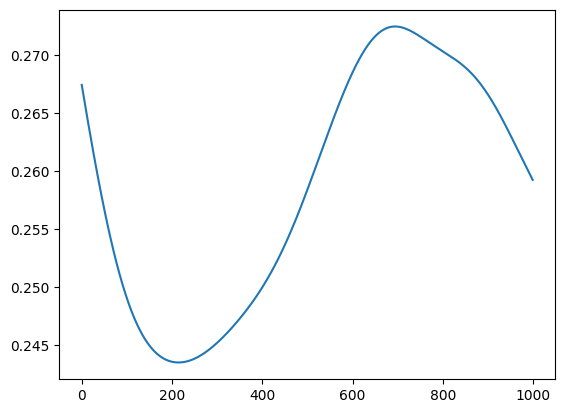

In [9]:
import matplotlib.pyplot as plt
plt.plot(loss_list)